In [1]:
import torch
import pandas as pd
import numpy as np
import torchvision.transforms as T
from torch import optim, nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
from torchmetrics import Accuracy
import matplotlib.pyplot as plt
import random

In [2]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None):
    model.train()
    loss_train = AverageMeter()
    acc = Accuracy('multiclass', num_classes=4, ignore_index=0).to(device)
    with tqdm(train_loader, unit='batch') as tepochs:
        for img, mask in tepochs:
            if epoch is not None:
                tepochs.set_description(f'epoch:{epoch}')
            yp = model(img.to(device)) # b , 4, h, w  # mask, 
#             print(yp.shape)
            yp = yp.view(yp.size(0), yp.size(1), -1)
#             print(yp.shape)
            mask = mask.to(device).view(mask.size(0), -1)
#             print(mask.shape)
            loss = loss_fn(yp, mask)
            acc.update(yp, mask)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            tepochs.set_postfix(loss=loss_train.avg, accuracy=acc.compute().item())
            loss_train.update(loss.item())
    return model, loss_train.avg, acc.compute().item()

def evaluate(model, test_loader, loss_fn):
    model.eval()
    acc = Accuracy('multiclass', num_classes=4, ignore_index=0).to(device)
    loss_test = AverageMeter()
    with torch.no_grad():
        for img, mask in test_loader:
            yp = model(img.to(device))
            yp = yp.view(yp.size(0), yp.size(1), -1)
            mask = mask.to(device).view(mask.size(0), -1)
            loss = loss_fn(yp, mask)
            loss_test.update(loss.item())
            acc.update(yp, mask)

    print(loss_test.avg)
    print(acc.compute().item())
    return loss_test.avg, acc.compute().item()

def inference(how_many):
    for i in range(how_many):
        imgs, mask = next(iter(test_loader))
        r = random.randint(0, 9)

        with torch.no_grad():
            preds = model(imgs[r].unsqueeze(0).to(device))
        fig, axes = plt.subplots(1, 2, figsize=(7, 7))
        axes[0].imshow(mask[r].squeeze())
        axes[0].set_title('real mask')
        axes[1].imshow(preds.squeeze().softmax(0).argmax(0).cpu())
        axes[1].set_title('predicted mask')


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
df = pd.read_csv('data.csv')

In [5]:
def decode(coded, imshape):
    shape = imshape[0] * imshape[1]
    mask = np.asarray(coded.split(), dtype=int)
    st = mask[::2]
    le = mask[1::2]
    ends = st + le  
    imas = np.zeros(shape, dtype=int)
    for low, high in zip(st, ends):
        imas[low:high] = 1
    return imas.reshape(imshape)

In [6]:
with open('train.txt') as f :
    train = f.read().splitlines()
with open('test.txt') as f :
    test = f.read().splitlines()

In [7]:
def get_segmented_with_same_format(df):
    get_vals_train = list()
    get_vals_test = list()
    for i in range(0, len(df), 3):
        bakt = df.iloc[i:i+3].dropna().values
        if bakt.shape[0] != 0:
            if bakt[0][0] in train:
                get_vals_train.append(bakt)
            else:
                get_vals_test.append(bakt)
    return get_vals_train, get_vals_test

In [8]:
train_data, test_data = get_segmented_with_same_format(df)

In [9]:
train_transforms = T.Compose([
            T.Resize((256, 256)), T.Normalize(0.5, 0.5)
])
mask_transform = T.Resize((256, 256))

In [10]:
class MySegDataset(Dataset):
    
    def __init__(self, datas: list):
        classes = {'large_bowel': 1, 'stomach': 2, 'small_bowel' : 3}
        self.datas = datas
        tr = T.ToTensor()
        self.y = list()
        self.x = list()
        for sample in self.datas:
            ims = tr(Image.open(sample[0][-1]))
            decoded_image = torch.zeros((ims.shape[1:]), dtype=torch.long)
             # creating image with labels on each pixel shape 1xhxw background is zero
            for i in sample:
                temp_dec = decode(i[6], ims.shape[1:])
                decoded_image[temp_dec == 1] = classes[i[3]]
            self.y.append(mask_transform(decoded_image.unsqueeze(0))) 
            self.x.append(train_transforms(ims / 255))  # main Image
    def __getitem__(self, idx):
        return self.x[idx],  self.y[idx]
    
    def __len__(self):
        return len(self.x)
    

In [12]:
train_set = MySegDataset(train_data)
test_set = MySegDataset(test_data)

/home/vahid/anaconda3/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [13]:
train_loader = DataLoader(train_set, batch_size=10, shuffle=True)
test_loader = DataLoader(test_set, batch_size=10, shuffle=True)

In [14]:
class Block(nn.Module):
    
    def __init__(self, in_f, out_f, dropout=0.5):
        super().__init__()
        self.layers =  nn.Sequential(
                            nn.Conv2d(in_f, out_f, kernel_size=3, padding=1),
                            nn.BatchNorm2d(out_f),
                            nn.ReLU(),
                            nn.Dropout(dropout),
                            nn.Conv2d(out_f, out_f, kernel_size=3, padding=1),
                            nn.BatchNorm2d(out_f),
                            nn.ReLU(),
                            nn.Dropout(dropout)
                          )
    def forward(self, x):
        return self.layers(x)

In [15]:
class UBadNet(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        # down sample, decoder phase
        self.block1 = Block(1, 64)
        self.block2 = Block(64, 128)
        self.block3 = Block(128, 256)
        self.block4 = Block(256, 512)
        self.block5 = Block(512, 1024)
        self.block6 = Block(1024, 1024)
        
        # Going N_block for concated tensors on decoder
        self.n_bloc_1 = Block(1024, 512)
        self.n_bloc_2 = Block(512, 256)
        self.n_bloc_3 = Block(256, 128)
        self.n_bloc_4 = Block(128, 64)

        # up sample 
        self.upc_1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2,)
        self.upc_2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.upc_3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.upc_4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        
        
        self.last_layer = nn.Conv2d(64, 4, kernel_size=3, padding=1)
        
        self.mp = nn.MaxPool2d(kernel_size=3, padding=1, stride=2)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
    def forward(self, x):
        x_1 = self.block1(x) # 256 64
        x_m =  self.mp(x_1) # 128 64
        x_2 = self.block2(x_m) # 128 128
        x_m = self.mp(x_2) # 64 128
        x_3 = self.block3(x_m) # 64 256
        x_m = self.mp(x_3) # 32 256
        x_4 = self.block4(x_m) # 32 512
        x_m = self.mp(x_4) # 16 512
        x_5 = self.block5(x_m) # 16 1024
        
        y_temp = self.relu(self.dropout(self.upc_1(x_5))) # 32 512
        y = self.n_bloc_1(torch.cat([y_temp, x_4], dim=1)) # 32, 1024 > 32 512
        y_temp = self.relu(self.dropout(self.upc_2(y))) # 64 256
        y = self.n_bloc_2(torch.cat([y_temp, x_3], dim=1)) # 64, 512 > 64 256
        y_temp = self.relu(self.dropout(self.upc_3(y))) # 128 128
        y = self.n_bloc_3(torch.cat([y_temp, x_2], dim=1)) # 128, 256 >  128, 128
        y_temp = self.relu(self.dropout(self.upc_4(y))) # 256, 64
        y = self.n_bloc_4(torch.cat([y_temp, x_1], dim=1)) # 256, 128 > 256, 64
        
        y = self.last_layer(y) # going to be 256, num_classes
        return y

In [ ]:
model = UBadNet().to(device)

In [16]:
model = torch.load('modelx1.pt')

In [17]:
sum(p.numel() for p in model.parameters())

49925124

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.2, weight_decay=1e-4)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
loss_train_hist = list()
loss_valid_hist = list()
acc_train_hist = list()
acc_valid_hist = list()
epoch_counter = 0
best_loss = 1e+4

In [ ]:
n = 100
for epoch in range(n):
    model, train_loss, acc_train = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)
    valid_loss, acc_test = evaluate(model, test_loader, loss_fn)
    
    loss_train_hist.append(train_loss)
    loss_valid_hist.append(valid_loss)
    acc_train_hist.append(acc_train_hist)
    acc_valid_hist.append(acc_valid_hist)

    if best_loss > valid_loss:
        torch.save(model,'modelx1.pt')
        best_loss =  valid_loss
        print('Model SAVED') 

    epoch_counter +=1

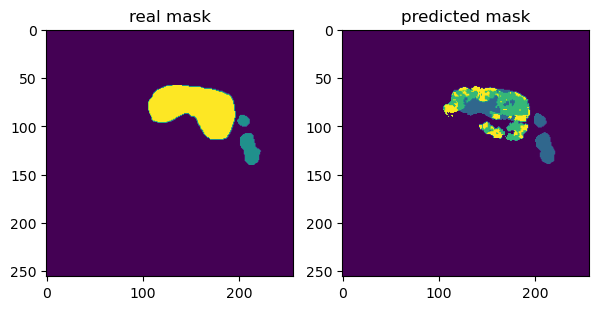

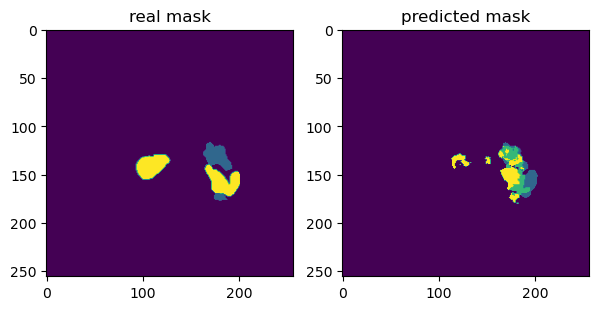

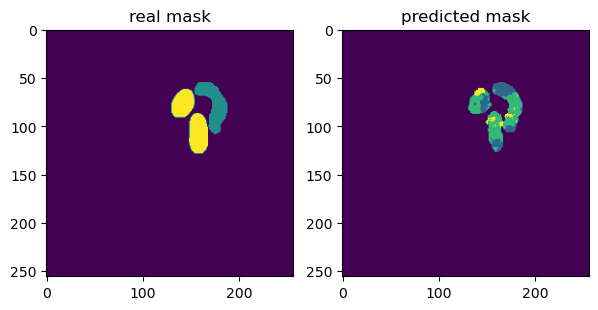

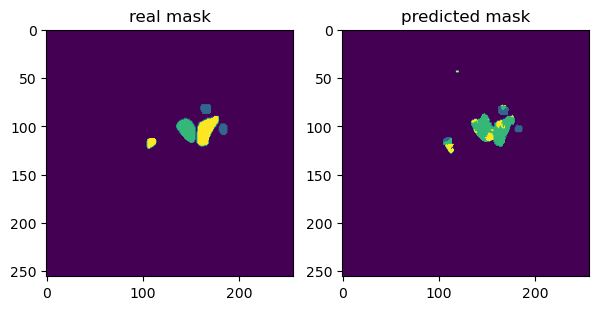

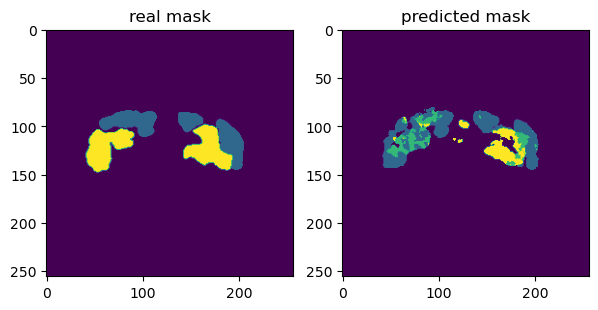

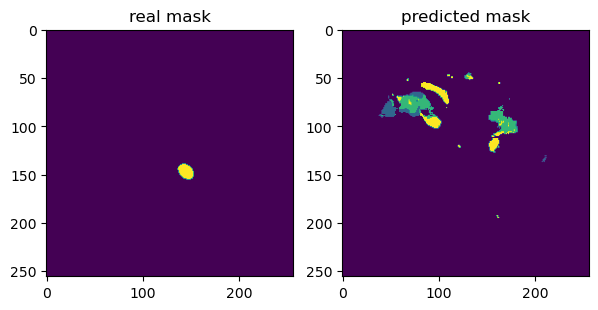

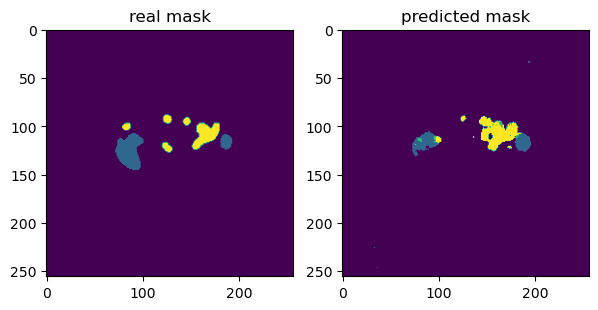

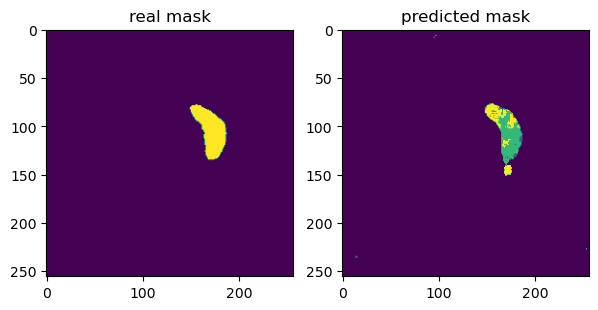

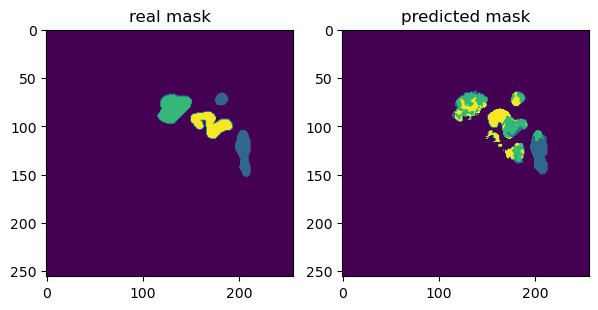

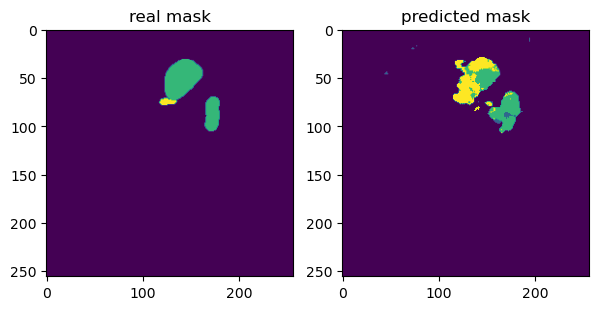

In [18]:
inference(10)